In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(61)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [5]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [6]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [7]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3350, grad_fn=<NegBackward0>)

 Exercise 1: backprop through the whole thing manually,  backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one


In [8]:
batch_size = 32
n = batch_size 
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) 
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

h = torch.tanh(hpreact) 

logits = h @ W2 + b2 

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes 
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4548, grad_fn=<NegBackward0>)

In [14]:
dloss = 1.0
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -(1 / n)
dlogprobs *= dloss
dlogprobs.shape, logprobs.shape
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [13]:
dprobs = 1 / probs * dlogprobs
dprobs.shape, probs.shape
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [15]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
dcounts_sum_inv.shape, counts_sum_inv.shape
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
dcounts_sum = (-1 * counts_sum ** (-2)) * dcounts_sum_inv
dcounts_sum.shape, counts_sum.shape
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
dcounts = (torch.ones_like(counts)) * dcounts_sum + (counts_sum_inv) * dprobs
dcounts.shape, counts.shape
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits.shape, norm_logits.shape
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [19]:
dlogit_maxes = (-1.0 * dnorm_logits).sum(1, keepdim=True)
dlogit_maxes.shape, logit_maxes.shape
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
temp = torch.zeros_like(logits)
temp[range(n), logits.max(1, keepdim=True).indices.view(-1, n)] = 1
dlogits = (norm_logits.exp()) * dcounts + (temp * dlogit_maxes)
dlogits.shape, logits.shape
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [21]:
dh = dlogits @ W2.T
dh.shape, h.shape
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
dW2 = h.T @ dlogits
dW2.shape, W2.shape
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


In [23]:
db2 = dlogits.sum(0, keepdim=True)
db2.shape, b2.shape
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [24]:
dhpreact = (1.0 - h**2) * dh
dhpreact.shape, hpreact.shape
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbngain.shape, bngain.shape
cmp('bngain', dbngain, bngain)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0


In [26]:
dbnraw = bngain * dhpreact
dbnraw.shape, bnraw.shape
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact: True  | approximate: True  | maxdiff: 0.0


In [27]:
dbnbias = ((1) * dhpreact).sum(0, keepdim=True)
dbnbias.shape, bnbias.shape
cmp('bnbias', dbnbias, bnbias)

bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


In [28]:
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar_inv.shape, bnvar_inv.shape
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


In [30]:
dbnvar = -0.5 * (bnvar + 1e-5) ** (-1.5) * (1) * dbnvar_inv
dbnvar.shape, bnvar.shape
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


In [31]:
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff2.shape, bndiff2.shape
dbndiff = bnvar_inv * dbnraw + 2 * bndiff * dbndiff2
dbndiff.shape, bndiff.shape
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


In [32]:
dbnmeani = (-1.0 * dbndiff).sum(0, keepdims=True)
dbnmeani.shape, bnmeani.shape
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


In [33]:
dhprebn = 1.0 * dbndiff + 1/ n * torch.ones_like(hprebn) * dbnmeani
dhprebn.shape, hprebn.shape
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


In [34]:
dembcat = dhprebn @ W1.T
dembcat.shape, embcat.shape
cmp('embcat', dembcat, embcat)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0


In [35]:
dW1 = embcat.T @ dhprebn
dW1.shape, W1.shape 
cmp('W1', dW1, W1)

W1              | exact: True  | approximate: True  | maxdiff: 0.0


In [36]:
db1 = dhprebn.sum(0, keepdims=True)
db1.shape, b1.shape
cmp('b1', db1, b1)

b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [37]:
demb = (1.0 * dembcat).view(emb.shape)
demb.shape, emb.shape
cmp('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


In [40]:
C[Xb].shape
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        idx = Xb[k, j]
        dC[idx] += demb[k, j]
dC.shape, C.shape
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


In [41]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = (-1 / n) * 1.0
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = ((counts) * dprobs).sum(1, keepdim=True)
dcounts_sum = (-1 * counts_sum ** (-2)) * dcounts_sum_inv
dcounts = (counts_sum_inv * dprobs) + torch.ones_like(counts) * dcounts_sum
dnorm_logits = (norm_logits.exp()) * dcounts
dlogit_maxes = ((-1) * dnorm_logits).sum(1, keepdim=True)
temp = torch.zeros_like(logits)
temp[range(n), logits.max(1, keepdim=True).indices.view(-1, n)] = 1
dlogits = (norm_logits.exp()) * dcounts + (temp * dlogit_maxes)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 =  dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** (-1.5)) * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) *  dbnvar
dbndiff = bnvar_inv * dbnraw + (2 * bndiff) * dbndiff2
dbnmeani = (-1 * dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone() + (1/n) * torch.ones_like(hprebn) *  dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        idx = Xb[k, j]
        dC[idx] += demb[k, j]

In [42]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

2. backprop through cross_entropy but all in one go, to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out*

In [43]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.4548120498657227 diff: -2.384185791015625e-07


In [45]:
prob = logits.exp() / (logits.exp().sum(1, keepdim=True))
prob[range(n), Yb] = prob[range(n), Yb] - 1
dloss_fast = 1 / n
dlogits = prob * dloss_fast
cmp('logits', dlogits, logits) 

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


3. Visualize the derivative of logits for a random forward pass, for a good forward pass (where we get lets say 70 % of predictions right) and for a perfect forward pass, what is happening with the derivative of logits and why ?

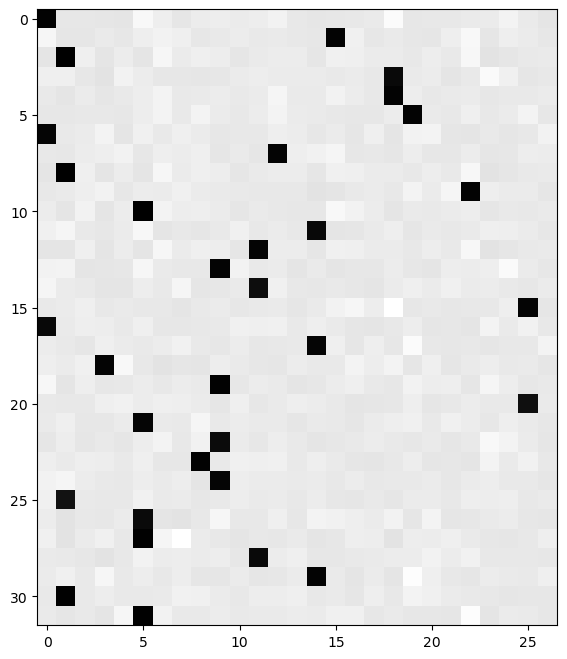

In [46]:
loss_fast = F.cross_entropy(logits, Yb)
prob = logits.exp() / (logits.exp().sum(1, keepdim=True))
prob[range(n), Yb] = prob[range(n), Yb] - 1
dloss_fast = 1 / n
dlogits = prob * dloss_fast
plt.figure(figsize=(8, 8))
plt.imshow(
    dlogits.detach(),
    cmap="gray"
)

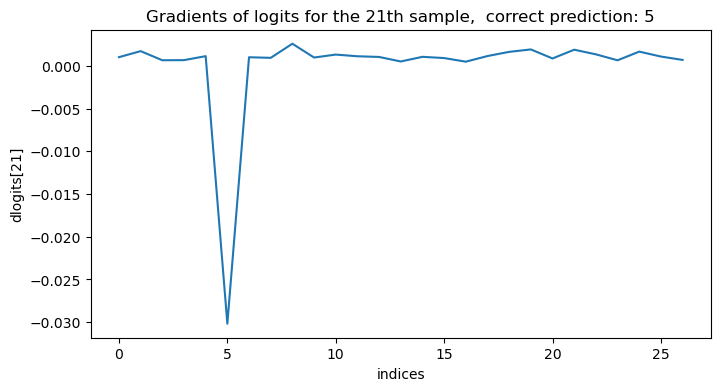

In [47]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits.detach()[21])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 21th sample,  correct prediction: {Yb[21]}");

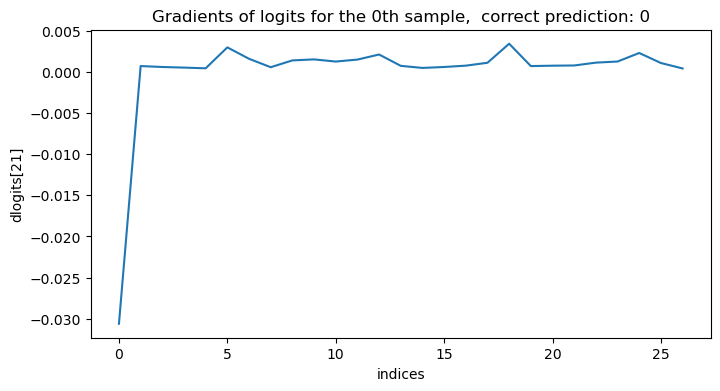

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits.detach()[0])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 0th sample,  correct prediction: {Yb[0]}");

In [49]:
rand_idx = torch.randperm(n)[:int(n * 0.7)]
logits_good = logits.clone()
logits_good[rand_idx, Yb[rand_idx]] = 20.0
loss_fast_good = F.cross_entropy(logits_good, Yb)
loss_fast_good

tensor(1.0992, grad_fn=<NllLossBackward0>)

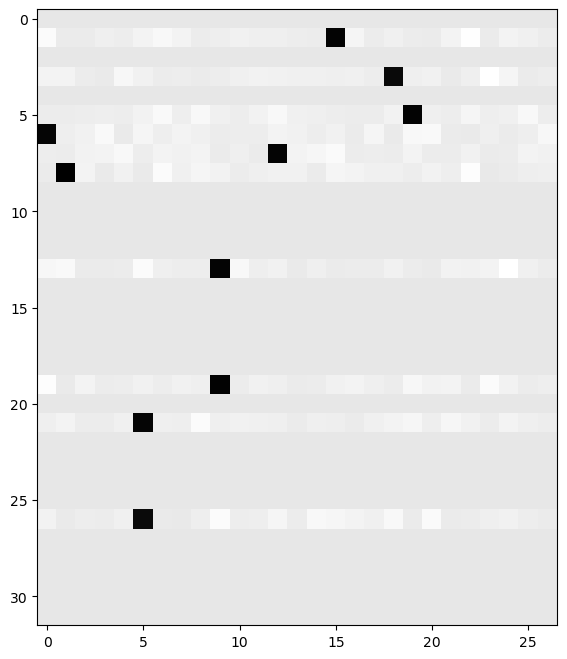

In [51]:
prob_good = F.softmax(logits_good, 1)
prob_good[range(n), Yb] = prob_good[range(n), Yb] - 1
dlogits_good = prob_good * loss_fast_good
plt.figure(figsize=(8, 8))
plt.imshow(
    dlogits_good.detach(),
    cmap="gray"
)

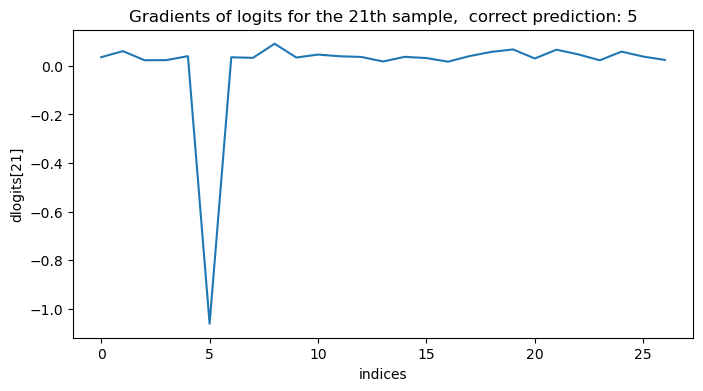

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_good.detach()[21])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 21th sample,  correct prediction: {Yb[21]}");

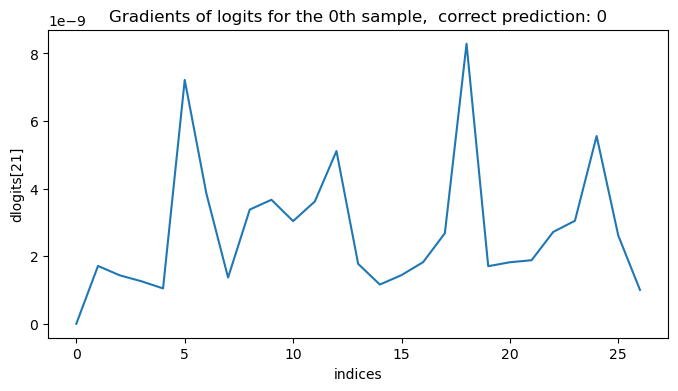

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_good.detach()[0])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 0th sample,  correct prediction: {Yb[0]}");

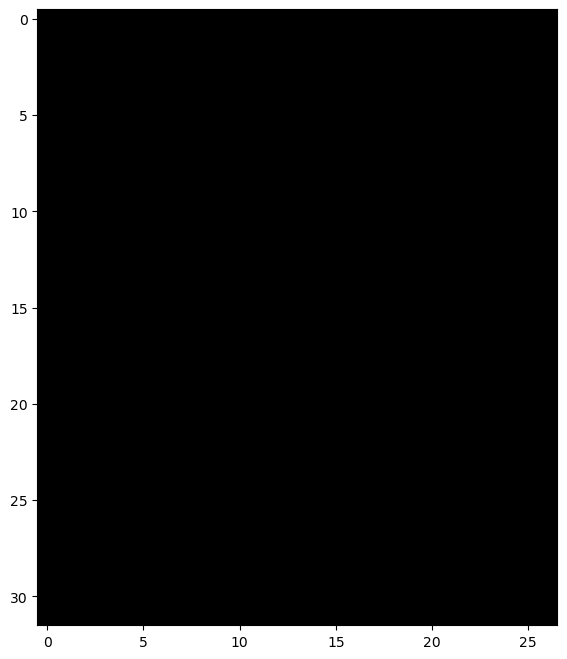

In [55]:
logits_perf = torch.zeros_like(logits)
logits_perf[range(n), Yb] = 20.0
loss_fast_perf = F.cross_entropy(logits_perf, Yb)
prob_pref = F.softmax(logits_perf, 1)
prob_pref[range(n), Yb] = prob_pref[range(n), Yb] - 1
dlogits_perf = prob_pref * loss_fast_perf
plt.figure(figsize=(8, 8))
plt.imshow(
    dlogits_perf.detach(),
    cmap="gray"
)

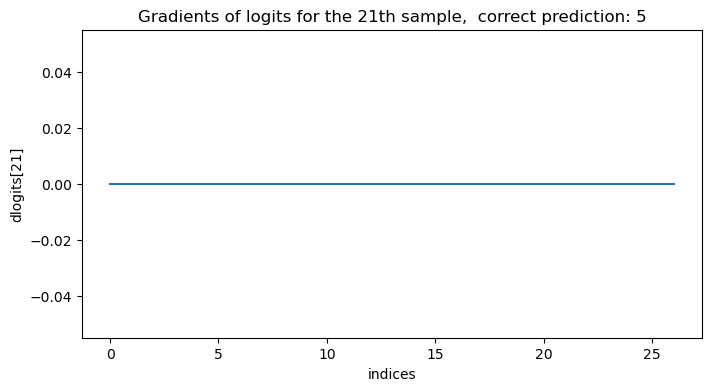

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_perf.detach()[21])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 21th sample,  correct prediction: {Yb[21]}");

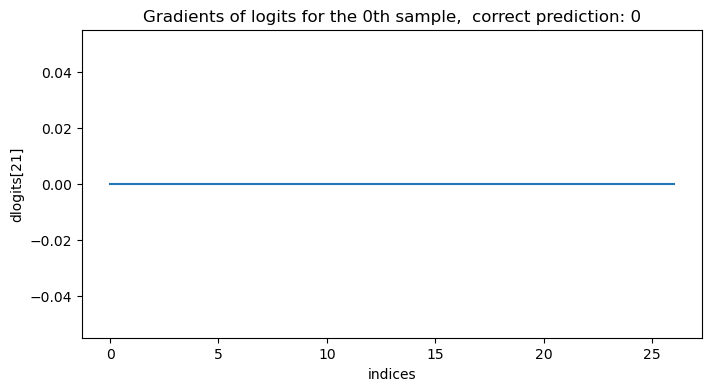

In [57]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_perf.detach()[0])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 0th sample,  correct prediction: {Yb[0]}");

4. backprop through batchnorm but all in one go, to complete this challenge look at the mathematical expression of the output of batchnorm,+take the derivative w.r.t. its input, simplify the expression, and just write it out, BatchNorm paper: https://arxiv.org/abs/1502.03167*

In [58]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [59]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [60]:
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(6161616161) 
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []


for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1) 
  hprebn = embcat @ W1 + b1 
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb) 


  for p in parameters:
    p.grad = None

  dlogits = F.softmax(logits, 1)
  dlogits[range(n), Yb] -= 1
  dlogits /= n
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  dhpreact = (1.0 - h**2) * dh
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

  lr = 0.1 if i < 100000 else 0.01 
  for p, grad in zip(parameters, grads):
    p.data += -lr * grad 

  if i % 10000 == 0: 
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

12297
      0/ 200000: 3.7820
  10000/ 200000: 2.2099
  20000/ 200000: 2.3666
  30000/ 200000: 2.4716
  40000/ 200000: 1.9924
  50000/ 200000: 2.3678
  60000/ 200000: 2.4309
  70000/ 200000: 2.0861
  80000/ 200000: 2.3845
  90000/ 200000: 2.1462
 100000/ 200000: 1.9276
 110000/ 200000: 2.3595
 120000/ 200000: 2.0140
 130000/ 200000: 2.5309
 140000/ 200000: 2.3971
 150000/ 200000: 2.1939
 160000/ 200000: 1.9242
 170000/ 200000: 1.8180
 180000/ 200000: 2.0529
 190000/ 200000: 1.8802
